
# Getting Started

This dashboard demonstrates several ways of interacting with ORE in a Jupyter notebook 
- Portfolio: Single Swap
- Market: Minimal setup with flat curves
- Analytics: Valuation, cashflows, sensitivities, exposure simulation and XVA

Prerequisites:
- Python 3
- ORE Python module: run "**pip install open-source-risk-engine**" to get the latest version

## Launch ORE

Kick off a process in ORE, loading all inputs from Input/ore.xml and the files referenced therein. 
This is equivalent to using the ORE command line application.

In [1]:
from ORE import *
import sys, time, math
sys.path.append('..')
import utilities

params = Parameters()
params.fromFile("Input/ore.xml")

ore = OREApp(params)


In [2]:
ore.run()

utilities.checkErrorsAndRunTime(ore)

Run time: 0.02 sec
Errors: 0


## Query Inputs

ore.run() should have loaded and compiled the main inputs
- portfolio
- today's market configuration
- conventions
- curve configrations
- pricing engine configuration

see Input/ore.xml. We spot check the loaded portfolio, print the xml tree to the screen:

In [3]:
portfolio = ore.getInputs().portfolio()
print("Trades:", portfolio.size())
for id in portfolio.ids():
    trade = portfolio.get(id)
    print("Trade:  id=%s type=%s" % (id, trade.tradeType()))

portfolioXML = portfolio.toXMLString()
print()
print(portfolioXML)

Trades: 1
Trade:  id=Swap type=Swap

<Portfolio>
	<Trade id="Swap">
		<TradeType>Swap</TradeType>
		<Envelope>
			<CounterParty>CPTY_A</CounterParty>
			<NettingSetId>CPTY_A</NettingSetId>
			<PortfolioIds/>
			<AdditionalFields/>
		</Envelope>
		<SwapData>
			<LegData>
				<LegType>Fixed</LegType>
				<Payer>false</Payer>
				<Currency>EUR</Currency>
				<PaymentConvention>MF</PaymentConvention>
				<DayCounter>A360</DayCounter>
				<Notionals>
					<Notional>10000000</Notional>
					<Exchanges>
						<NotionalInitialExchange>false</NotionalInitialExchange>
						<NotionalFinalExchange>false</NotionalFinalExchange>
						<NotionalAmortizingExchange>false</NotionalAmortizingExchange>
					</Exchanges>
				</Notionals>
				<ScheduleData>
					<Rules>
						<StartDate>20160209</StartDate>
						<EndDate>20360209</EndDate>
						<Tenor>1Y</Tenor>
						<Calendar>TARGET</Calendar>
						<Convention>MF</Convention>
						<TermConvention>MF</TermConvention>
						<Rule>Forward</Rule>
						<

## Query Results

The results of the ORE run above have been written to the Output folder.
Moreover all results are stored in memory and can be queried as follows.

First, double-check which analytics we have requested, see Input/ore.xml:

In [4]:
utilities.writeList(ore.getAnalyticTypes())


- CASHFLOW
- NPV


Now list all reports that have been generated:

In [5]:
utilities.writeList(ore.getReportNames())


- cashflow
- curves
- dividends
- fixings
- marketdata
- npv
- pricingstats
- runtimes
- todaysmarketcalibration


## NPV report

Pick the npv report, check its structure...

In [6]:
reportName = "npv"
report = ore.getReport(reportName)
utilities.checkReportStructure(reportName, report)

Report:  npv
columns: 13
rows:    1

Column Header               Type     TypeString
0      TradeId              2        string    
1      TradeType            2        string    
2      Maturity             3        Date      
3      MaturityTime         1        Real      
4      NPV                  1        Real      
5      NpvCurrency          2        string    
6      NPV(Base)            1        Real      
7      BaseCurrency         2        string    
8      Notional             1        Real      
9      NotionalCurrency     2        string    
10     Notional(Base)       1        Real      
11     NettingSet           2        string    
12     CounterParty         2        string    


... and write a subset of the NPV report columns (0, 1, 2, 4, 5):

In [7]:
utilities.writeReport(report, [0, 1, 2, 4, 5])


TradeId            TradeType          Maturity           NPV                NpvCurrency        
Swap               Swap               2036-02-11         1335.2704          EUR                


In [8]:
display(utilities.format_report(report))

,TradeId,TradeType,Maturity,MaturityTime,NPV,NpvCurrency,NPV(Base),BaseCurrency,Notional,NotionalCurrency,Notional(Base),NettingSet,CounterParty
0,Swap,Swap,2036-02-11,20.016393,1335.270448,EUR,1335.270448,EUR,10000000.0,EUR,10000000.0,CPTY_A,CPTY_A


## Inspect the cashflow report

Pick the cashflow report, check its structure...

In [9]:
reportName = "cashflow"
report = ore.getReport(reportName)
utilities.checkReportStructure(reportName, report)

Report:  cashflow
columns: 27
rows:    60

Column Header               Type     TypeString
0      TradeId              2        string    
1      Type                 2        string    
2      CashflowNo           0        Size      
3      LegNo                0        Size      
4      PayDate              3        Date      
5      FlowType             2        string    
6      Amount               1        Real      
7      Currency             2        string    
8      Coupon               1        Real      
9      Accrual              1        Real      
10     AccrualStartDate     3        Date      
11     AccrualEndDate       3        Date      
12     AccruedAmount        1        Real      
13     fixingDate           3        Date      
14     fixingValue          1        Real      
15     Notional             1        Real      
16     DiscountFactor       1        Real      
17     PresentValue         1        Real      
18     FXRate(Local-Base)   1        Real    

... and write a subset of the cashflow report columns:

In [10]:
utilities.writeReport(report, [2, 3, 4, 5, 6])


CashflowNo         LegNo              PayDate            FlowType           Amount             
1                  0                  2017-02-09         Interest           213500.0000        
2                  0                  2018-02-09         Interest           212916.6667        
3                  0                  2019-02-11         Interest           214083.3333        
4                  0                  2020-02-10         Interest           212333.3333        
5                  0                  2021-02-09         Interest           212916.6667        
6                  0                  2022-02-09         Interest           212916.6667        
7                  0                  2023-02-09         Interest           212916.6667        
8                  0                  2024-02-09         Interest           212916.6667        
9                  0                  2025-02-10         Interest           214083.3333        
10                 0                  2

## Curves report

See which curves have been written. Compare to the configuration in Input/todaysmarket.xml. 

In [11]:
reportName = "curves"
report = ore.getReport(reportName)
utilities.checkReportStructure(reportName, report)

Report:  curves
columns: 15
rows:    240

Column Header               Type     TypeString
0      Tenor                4        Period    
1      Date                 3        Date      
2      EUR                  1        Real      
3      GBP                  1        Real      
4      USD                  1        Real      
5      BANK_EUR_BORROW      1        Real      
6      BANK_EUR_LEND        1        Real      
7      EUR-EONIA            1        Real      
8      EUR-EURIBOR-6M       1        Real      
9      GBP-LIBOR-3M         1        Real      
10     GBP-LIBOR-6M         1        Real      
11     GBP-SONIA            1        Real      
12     BANK                 1        Real      
13     CPTY_A               1        Real      
14     CPTY_B               1        Real      


Now pick the EUR, GBP and USD discount curves, convert dates into times and discounts into zero rates: 

In [12]:
asof = ore.getInputs().asof()

date = report.dataAsDate(1)
eurDiscount = report.dataAsReal(2)
gbpDiscount = report.dataAsReal(3)
usdDiscount = report.dataAsReal(4)
time = [0] * report.rows()
eurZero = [0] * report.rows() 
gbpZero = [0] * report.rows() 
usdZero = [0] * report.rows() 

dc = Actual365Fixed()
#print ("#Index", "Date", "Discount")
for i in range(0, report.rows()):
    time[i] = dc.yearFraction(asof, date[i])
    eurZero[i] = -math.log(eurDiscount[i]) / time[i]
    gbpZero[i] = -math.log(gbpDiscount[i]) / time[i]
    usdZero[i] = -math.log(usdDiscount[i]) / time[i]
    #print("%d %s %.4f %.8f %.8f" % (i, date[i].ISO(), time[i], eurZero[i], gbpZero[i]))

... and plot the curves:

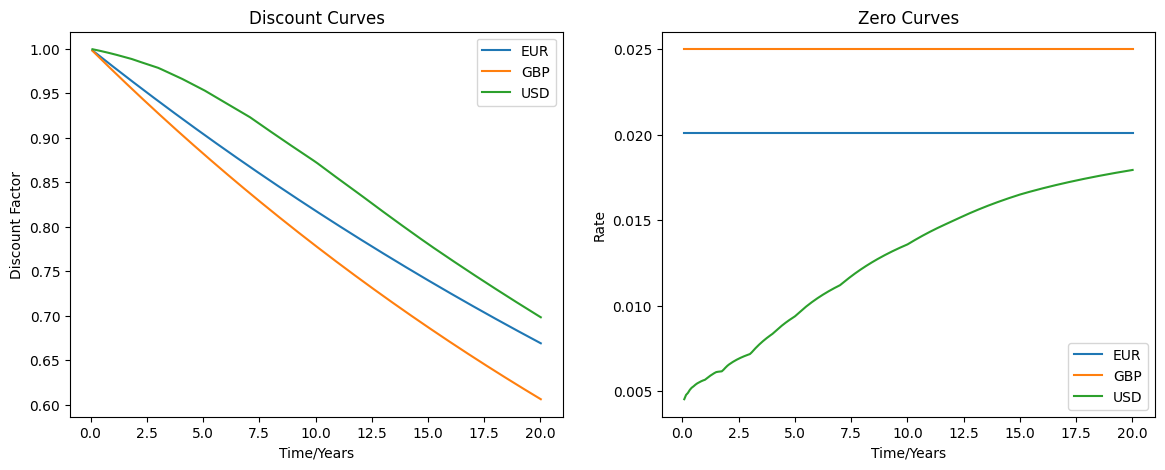

In [13]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14, 5))
gs = GridSpec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.plot(time, eurDiscount, label='EUR')
ax0.plot(time, gbpDiscount, label='GBP')
ax0.plot(time, usdDiscount, label='USD')
ax0.set(xlabel='Time/Years', ylabel='Discount Factor')
ax0.set_title('Discount Curves')
ax0.legend()
ax1.plot(time, eurZero, label='EUR')
ax1.plot(time, gbpZero, label='GBP')
ax1.plot(time, usdZero, label='USD')
ax1.set(xlabel='Time/Years', ylabel='Rate')
ax1.set_title('Zero Curves')
ax1.legend()

plt.show()

EUR and GBP zero curves are flat, as expected.

## Sensitivity Analysis

We could now modify the inputs via ore.xml and run again to generate a sensitivity report.

But we can also do it here. It requires two additional configurations:

In [14]:
sensiXML = """
<SensitivityAnalysis>
  <DiscountCurves>
    <DiscountCurve ccy='EUR'>
      <ShiftType>Absolute</ShiftType>
      <ShiftSize>0.0001</ShiftSize>
      <ShiftTenors>2W,1M,3M,6M,9M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,25Y,30Y</ShiftTenors>
      <ParConversion>
        <Instruments>OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS</Instruments>
        <SingleCurve>true</SingleCurve>
        <Conventions>
            <Convention id='DEP'>EUR-EURIBOR-CONVENTIONS</Convention>
            <Convention id='IRS'>EUR-6M-SWAP-CONVENTIONS</Convention>
            <Convention id='OIS'>EUR-OIS-CONVENTIONS</Convention>
        </Conventions>
      </ParConversion>
    </DiscountCurve>
  </DiscountCurves>
  <IndexCurves>
    <IndexCurve index='EUR-EONIA'>
      <ShiftType>Absolute</ShiftType>
      <ShiftSize>0.0001</ShiftSize>
      <ShiftTenors>2W,1M,3M,6M,9M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,25Y,30Y</ShiftTenors>
      <ParConversion>
        <Instruments>OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS</Instruments>
        <SingleCurve>true</SingleCurve>
        <Conventions>
            <Convention id='DEP'>EUR-EURIBOR-CONVENTIONS</Convention>
            <Convention id='IRS'>EUR-6M-SWAP-CONVENTIONS</Convention>
            <Convention id='OIS'>EUR-OIS-CONVENTIONS</Convention>
        </Conventions>
      </ParConversion>
    </IndexCurve>
    <IndexCurve index='EUR-EURIBOR-6M'>
      <ShiftType>Absolute</ShiftType>
      <ShiftSize>0.0001</ShiftSize>
      <ShiftTenors>2W,1M,3M,6M,9M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,25Y,30Y</ShiftTenors>
      <ParConversion>
        <Instruments>DEP,DEP,DEP,DEP,DEP,IRS,IRS,IRS,IRS,IRS,IRS,IRS,IRS,IRS,IRS,IRS</Instruments>
        <SingleCurve>false</SingleCurve>
        <Conventions>
            <Convention id='DEP'>EUR-EURIBOR-CONVENTIONS</Convention>
            <Convention id='IRS'>EUR-6M-SWAP-CONVENTIONS</Convention>
            <Convention id='OIS'>EUR-OIS-CONVENTIONS</Convention>
        </Conventions>
      </ParConversion>
    </IndexCurve>
  </IndexCurves>
</SensitivityAnalysis>
"""

In [15]:
simulationXML = """
<Simulation>
  <Market>
    <BaseCurrency>EUR</BaseCurrency>
    <Currencies>
      <Currency>EUR</Currency>
    </Currencies>
    <YieldCurves>
      <Configuration>
        <Tenors>2W,1M,3M,6M,9M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,25Y,30Y</Tenors>
        <Interpolation>LogLinear</Interpolation>
        <Extrapolation>Y</Extrapolation>
      </Configuration>
    </YieldCurves>
    <Indices>
      <Index>EUR-EONIA</Index>
      <Index>EUR-EURIBOR-6M</Index>
    </Indices>
  </Market>
</Simulation>
"""

In [16]:
inputs = ore.getInputs()
inputs.setSensiScenarioData(sensiXML)
inputs.setSensiSimMarketParams(simulationXML)
inputs.insertAnalytic("SENSITIVITY")

Run again...

In [17]:
ore.run()

utilities.checkErrorsAndRunTime(ore)        

Run time: 0.04 sec
Errors: 1
{ "category": "Warning", "group": "Fixing", "message": "Could not find required fixing ID.", "sub_fields": [ { "name": "exceptionType", "value": "Missing fixing" }, { "name": "fixingDate", "value": "2016-02-05" }, { "name": "fixingId", "value": "EUR-EURIBOR-6M" } ] }


Check result reports again...

In [18]:
utilities.writeList(ore.getReportNames())


- cashflow
- curves
- dividends
- fixings
- marketdata
- npv
- pricingstats
- runtimes
- sensitivity
- sensitivity_config
- sensitivity_scenario
- todaysmarketcalibration


We have a sensitivity report now

In [19]:
reportName = "sensitivity"
rawReport = ore.getReport(reportName)
utilities.checkReportStructure(reportName, rawReport)

Report:  sensitivity
columns: 10
rows:    25

Column Header               Type     TypeString
0      TradeId              2        string    
1      IsPar                2        string    
2      Factor_1             2        string    
3      ShiftSize_1          1        Real      
4      Factor_2             2        string    
5      ShiftSize_2          1        Real      
6      Currency             2        string    
7      Base NPV             1        Real      
8      Delta                1        Real      
9      Gamma                1        Real      


In [20]:
isPar = rawReport.dataAsString(1)
factor = rawReport.dataAsString(2)
shiftSize = rawReport.dataAsReal(3)
currency = rawReport.dataAsString(6)
npv = rawReport.dataAsReal(7)
delta = rawReport.dataAsReal(8) 
gamma = rawReport.dataAsReal(9)
print ("%-10s %-35s %10s %10s %10s %10s %10s" % ("IsPar", "Factor", "ShiftSize", "Currency", "NPV", "Delta", "Gamma"))
rawDelta = {}
for i in range(0, rawReport.rows()):
    print("%-10s %-35s %10.6f %10s %10.2f %10.2f %10.2f" % (isPar[i], factor[i], shiftSize[i], currency[i], npv[i], delta[i], gamma[i]))
    if ("IndexCurve" in factor[i]):
        rawDelta[factor[i]] = delta[i]


IsPar      Factor                               ShiftSize   Currency        NPV      Delta      Gamma
false      DiscountCurve/EUR/3/6M                0.000100        EUR    1335.27       5.05      -0.00
false      DiscountCurve/EUR/4/9M                0.000100        EUR    1335.27       0.35      -0.00
false      DiscountCurve/EUR/5/1Y                0.000100        EUR    1335.27      -5.41       0.00
false      DiscountCurve/EUR/6/2Y                0.000100        EUR    1335.27      -0.22       0.00
false      DiscountCurve/EUR/7/3Y                0.000100        EUR    1335.27      -0.32       0.00
false      DiscountCurve/EUR/8/4Y                0.000100        EUR    1335.27      -0.39       0.01
false      DiscountCurve/EUR/9/5Y                0.000100        EUR    1335.27      -0.84       0.01
false      DiscountCurve/EUR/10/7Y               0.000100        EUR    1335.27      -1.72       0.01
false      DiscountCurve/EUR/11/10Y              0.000100        EUR    1335.27   

Note that relevant sensitivities are spread across several buckets on both discount and index curve. 

We want par sensitivities as well:

In [21]:
inputs.setParSensi(True)

In [22]:
ore.run()

utilities.checkErrorsAndRunTime(ore)        

Run time: 0.05 sec
Errors: 1
{ "category": "Warning", "group": "Fixing", "message": "Could not find required fixing ID.", "sub_fields": [ { "name": "exceptionType", "value": "Missing fixing" }, { "name": "fixingDate", "value": "2016-02-05" }, { "name": "fixingId", "value": "EUR-EURIBOR-6M" } ] }


In [23]:
utilities.writeList(ore.getReportNames())


- cashflow
- curves
- dividends
- fixings
- marketdata
- npv
- par_sensitivity
- pricingstats
- runtimes
- sensitivity
- sensitivity_config
- sensitivity_scenario
- todaysmarketcalibration


We have a par sensitivity report now

In [24]:
parReportName = "par_sensitivity"
print ("Load report", parReportName)
parReport = ore.getReport(parReportName)
    
isPar = parReport.dataAsString(1)
factor = parReport.dataAsString(2)
shiftSize = parReport.dataAsReal(3)
currency = parReport.dataAsString(6)
npv = parReport.dataAsReal(7)
delta = parReport.dataAsReal(8) 

print("\n")
print ("%-10s %-35s %10s %10s %10s %10s" % ("IsPar", "Factor", "ShiftSize", "Currency", "NPV", "ParDelta"))
parDelta = {}
for i in range(0, parReport.rows()):
    print("%-10s %-35s %10.6f %10s %10.2f %10.2f" % (isPar[i], factor[i], shiftSize[i], currency[i], npv[i], delta[i]))
    if ("IndexCurve" in factor[i]):
        parDelta[factor[i]] = delta[i]


Load report par_sensitivity


IsPar      Factor                               ShiftSize   Currency        NPV   ParDelta
true       DiscountCurve/EUR/0/2W                0.000100        EUR    1335.27      -0.00
true       DiscountCurve/EUR/1/1M                0.000100        EUR    1335.27       0.00
true       DiscountCurve/EUR/2/3M                0.000100        EUR    1335.27      -0.00
true       DiscountCurve/EUR/3/6M                0.000100        EUR    1335.27       0.00
true       DiscountCurve/EUR/4/9M                0.000100        EUR    1335.27      -0.00
true       DiscountCurve/EUR/5/1Y                0.000100        EUR    1335.27      -0.01
true       DiscountCurve/EUR/6/2Y                0.000100        EUR    1335.27      -0.01
true       DiscountCurve/EUR/7/3Y                0.000100        EUR    1335.27      -0.02
true       DiscountCurve/EUR/8/4Y                0.000100        EUR    1335.27      -0.02
true       DiscountCurve/EUR/9/5Y                0.000100   

with the expected single index curve bucket sensitivity.

## Exposure Simulation

To run an exposure simulation, we need to add further configurations:
- simulation market configuration
- scenario generator configuration
- cross asset model configuration
- netting set manager

In [25]:
mcSimMarketXML ="""
<Simulation>
<Market>
  <BaseCurrency>EUR</BaseCurrency>
    <Currencies>
      <Currency>EUR</Currency>
    </Currencies>
  <YieldCurves>
    <Configuration>
      <Tenors>3M,6M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,12Y,15Y,20Y,25Y,30Y</Tenors>
      <Interpolation>LogLinear</Interpolation>
      <Extrapolation>Y</Extrapolation>
    </Configuration>
  </YieldCurves>
  <Indices>
    <Index>EUR-EURIBOR-6M</Index>
    <Index>EUR-EONIA</Index>
  </Indices>
  <SwapIndices>
    <SwapIndex>
      <Name>EUR-CMS-1Y</Name>
      <DiscountingIndex>EUR-EONIA</DiscountingIndex>
    </SwapIndex>
    <SwapIndex>
      <Name>EUR-CMS-30Y</Name>
      <DiscountingIndex>EUR-EONIA</DiscountingIndex>
    </SwapIndex>
  </SwapIndices>
  <DefaultCurves>
    <Names/>
    <Tenors>6M,1Y,2Y</Tenors>
  </DefaultCurves>
  <AggregationScenarioDataCurrencies>
    <Currency>EUR</Currency>
  </AggregationScenarioDataCurrencies>
  <AggregationScenarioDataIndices>
    <Index>EUR-EONIA</Index>
  </AggregationScenarioDataIndices>
</Market>
</Simulation>
"""

In [26]:
scenarioGeneratorXML ="""
<Simulation>
  <Parameters>
    <Discretization>Exact</Discretization>
    <Grid>81,3M</Grid>
    <Calendar>EUR</Calendar>
    <Sequence>SobolBrownianBridge</Sequence>
    <Scenario>Simple</Scenario>
    <Seed>42</Seed>
    <Samples>1000</Samples>
  </Parameters>
</Simulation>
"""

In [27]:
crossAssetModelXML = """
<Simulation>
<CrossAssetModel>
  <DomesticCcy>EUR</DomesticCcy>
  <Currencies>
    <Currency>EUR</Currency>
  </Currencies>
  <BootstrapTolerance>0.0001</BootstrapTolerance>
  <InterestRateModels>
    <LGM ccy='default'>
      <CalibrationType>Bootstrap</CalibrationType>
      <Volatility>
        <Calibrate>Y</Calibrate>
        <VolatilityType>Hagan</VolatilityType>
        <ParamType>Piecewise</ParamType>
        <TimeGrid>1.0,2.0,3.0,4.0,5.0,7.0,10.0</TimeGrid>
        <InitialValue>0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01</InitialValue>
      </Volatility>
      <Reversion>
        <Calibrate>N</Calibrate>
        <ReversionType>HullWhite</ReversionType>
        <ParamType>Constant</ParamType>
        <TimeGrid/>
        <InitialValue>0.03</InitialValue>
      </Reversion>
      <CalibrationSwaptions>
        <Expiries> 1Y,  2Y,  4Y,  6Y,  8Y, 10Y, 12Y, 14Y, 16Y, 18Y, 19Y</Expiries>
        <Terms>   19Y, 18Y, 16Y, 14Y, 12Y, 10Y,  8Y,  6Y,  4Y,  2Y,  1Y</Terms>
        <Strikes/>
      </CalibrationSwaptions>
      <ParameterTransformation>
        <ShiftHorizon>0.0</ShiftHorizon>
        <Scaling>1.0</Scaling>
      </ParameterTransformation>
   </LGM>
  </InterestRateModels>
  <ForeignExchangeModels>
    <CrossCcyLGM foreignCcy='default'>
      <DomesticCcy>EUR</DomesticCcy>
      <CalibrationType>Bootstrap</CalibrationType>
      <Sigma>
        <Calibrate>Y</Calibrate>
        <ParamType>Piecewise</ParamType>
        <TimeGrid>1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0</TimeGrid>
        <InitialValue>0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1</InitialValue>
      </Sigma>
      <CalibrationOptions>
        <Expiries>1Y, 2Y, 3Y, 4Y, 5Y, 10Y</Expiries>
        <Strikes/>
      </CalibrationOptions>
    </CrossCcyLGM>
  </ForeignExchangeModels>
  <InstantaneousCorrelations>
    <Correlation factor1='IR:EUR' factor2='IR:GBP'>0.3</Correlation>
    <Correlation factor1='IR:EUR' factor2='FX:GBPEUR'>0</Correlation>
    <Correlation factor1='IR:GBP' factor2='FX:GBPEUR'>0</Correlation>
  </InstantaneousCorrelations>
</CrossAssetModel>
</Simulation>
"""

In [28]:
nettingSetManagerXML = """
<NettingSetDefinitions>
  <NettingSet>
    <NettingSetId>CPTY_A</NettingSetId>
    <Counterparty>CPTY_A</Counterparty>
    <ActiveCSAFlag>false</ActiveCSAFlag>
    <CSADetails>
      <Bilateral>Bilateral</Bilateral>
      <CSACurrency>EUR</CSACurrency>
      <Index>EUR-EONIA</Index>
      <ThresholdPay>0</ThresholdPay>
      <ThresholdReceive>0</ThresholdReceive>
      <MinimumTransferAmountPay>0</MinimumTransferAmountPay>
      <MinimumTransferAmountReceive>0</MinimumTransferAmountReceive>
      <IndependentAmount>
        <IndependentAmountHeld>0</IndependentAmountHeld>
        <IndependentAmountType>FIXED</IndependentAmountType>
      </IndependentAmount>
      <MarginingFrequency>
        <CallFrequency>1D</CallFrequency>
        <PostFrequency>1D</PostFrequency>
      </MarginingFrequency>
      <MarginPeriodOfRisk>2W</MarginPeriodOfRisk>
      <CollateralCompoundingSpreadReceive>0.00</CollateralCompoundingSpreadReceive>
      <CollateralCompoundingSpreadPay>0.00</CollateralCompoundingSpreadPay>
      <EligibleCollaterals>
        <Currencies>
          <Currency>EUR</Currency>
        </Currencies>
      </EligibleCollaterals>
    </CSADetails>
  </NettingSet>
</NettingSetDefinitions>
"""

In [29]:
simulationPricingEngineXML = """
<PricingEngines>
<Product type='Swap'>
  <Model>DiscountedCashflows</Model>
  <ModelParameters/>
  <Engine>DiscountingSwapEngine</Engine>
  <EngineParameters/>
</Product>
</PricingEngines>
"""
amcPricingEngineXML = "<PricingEngines></PricingEngines>"

In [30]:
inputs.setExposureBaseCurrency("EUR")
inputs.setExposureSimMarketParams(mcSimMarketXML)
inputs.setScenarioGeneratorData(scenarioGeneratorXML)
inputs.setCrossAssetModelData(crossAssetModelXML)
inputs.setSimulationPricingEngine(simulationPricingEngineXML)
inputs.setAmcPricingEngine(amcPricingEngineXML)
inputs.setNettingSetManager(nettingSetManagerXML)
inputs.setWriteCube(True)
inputs.setXvaBaseCurrency("EUR")
inputs.setExposureProfiles(True)
inputs.setExposureProfilesByTrade(True)
inputs.setCvaAnalytic(True)
inputs.setAmc(False)
inputs.setNetCubeOutput(True)
inputs.setWriteCube(True)
inputs.setWriteScenarios(True)

inputs.insertAnalytic("EXPOSURE")
inputs.insertAnalytic("XVA")

In [31]:
ore.run()
utilities.checkErrorsAndRunTime(ore)     

Run time: 5.01 sec
Errors: 1
{ "category": "Warning", "group": "Fixing", "message": "Could not find required fixing ID.", "sub_fields": [ { "name": "exceptionType", "value": "Missing fixing" }, { "name": "fixingDate", "value": "2016-02-05" }, { "name": "fixingId", "value": "EUR-EURIBOR-6M" } ] }


In [32]:
utilities.writeList(ore.getReportNames())


- cashflow
- colva_nettingset_CPTY_A
- curves
- cva_sensitivity_nettingset_CPTY_A
- dividends
- exposure_nettingset_CPTY_A
- exposure_trade_Swap
- fixings
- marketdata
- netcube
- npv
- par_sensitivity
- pricingstats
- runtimes
- scenario
- sensitivity
- sensitivity_config
- sensitivity_scenario
- todaysmarketcalibration
- xva


We should have several additional reports now:
- exposure_trade_Swap
- exposure-nettingset_CPTY_A
- cva_sensitivity_nettingset_CPTY_A
- colva_nettingset_CPTY_A
- netcube
- xva

Let us check the simulated data (rates, NPVs) and the resulting exposure report:

dates:   82
samples: 1000
keys:    2


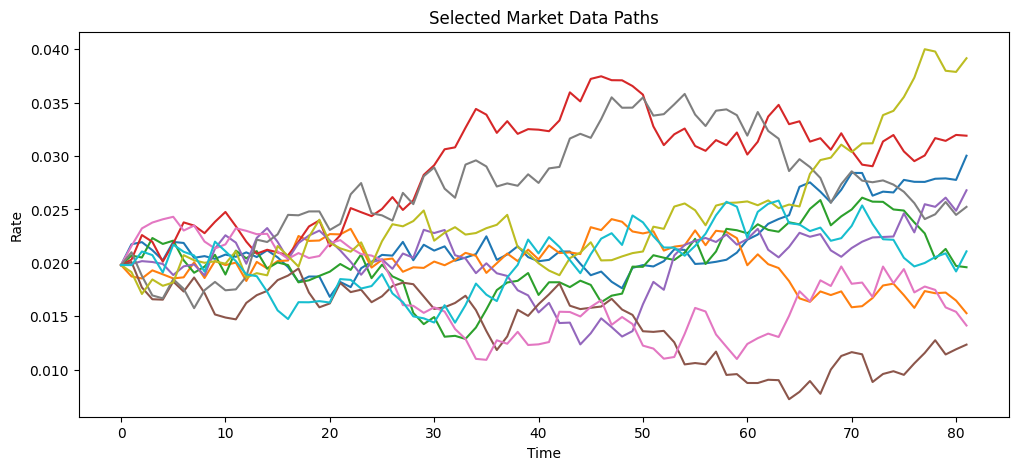

In [33]:
keyNumber = 0 # we store a single index (EONIA) in this case, hence key=0, compare to the file header
# The number of paths we want to see
numberOfPaths = 10
# Pick the t0 index fixing and pass it to the plot function below as starting point
analytic = ore.getAnalytic("XVA")
market = analytic.getMarket()
eoniaIndex = market.iborIndex("EUR-EONIA")
fixing = eoniaIndex.fixing(inputs.asof())
# We have outsourced the data loading and plotting to utilities
# Note that the output file scenariodata.csv.gz is only gzipped if ORE was compiled with zlib support (ORE_USE_ZLIB).
# Otherwise the ending is misleading, and the file is just an uncompressed csv. The utility deals with that.
utilities.plotScenarioDataPaths("Output/scenariodata.csv.gz", keyNumber, numberOfPaths, fixing)
# Todos:
# 1) add t0 fixings to the scenariodata object and file
# 2) extend the oreapp interface so that we can retrieve the scenariodata in memory

dates: 82
samples: 1001
depths: 1


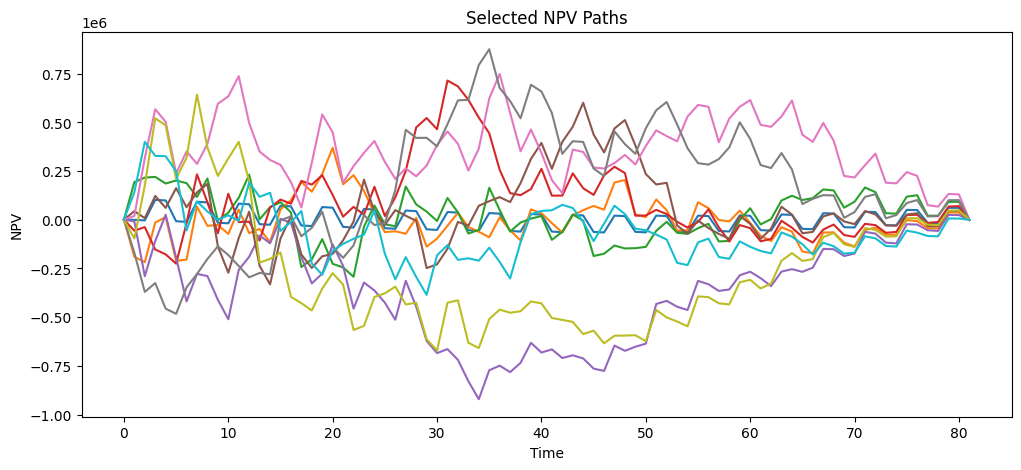

In [34]:
# Plotting the NPV paths is easier, since the cube report contains t0
cubeReport = ore.getReport("netcube")
numberOfPaths = 10
utilities.plotNpvPaths(cubeReport, numberOfPaths)

In [35]:
reportName = "exposure_trade_Swap"
report = ore.getReport(reportName)
utilities.checkReportStructure(reportName, rawReport)

Report:  exposure_trade_Swap
columns: 10
rows:    25

Column Header               Type     TypeString
0      TradeId              2        string    
1      IsPar                2        string    
2      Factor_1             2        string    
3      ShiftSize_1          1        Real      
4      Factor_2             2        string    
5      ShiftSize_2          1        Real      
6      Currency             2        string    
7      Base NPV             1        Real      
8      Delta                1        Real      
9      Gamma                1        Real      


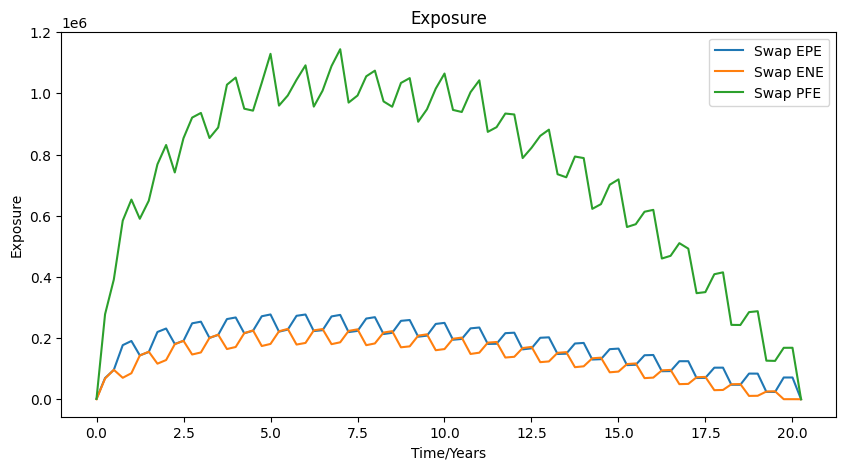

In [36]:
time = report.dataAsReal(2)
epe = report.dataAsReal(3);
ene = report.dataAsReal(4);
pfe = report.dataAsReal(7);
    
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0, 0])

ax.plot(time, epe, label='Swap EPE')
ax.plot(time, ene, label='Swap ENE')
ax.plot(time, pfe, label='Swap PFE')
ax.set(xlabel='Time/Years')
ax.set(ylabel='Exposure')
ax.set_title('Exposure')
ax.legend()

plt.show()

Finally, we can pick the trade or netting set CVA result from the xva report:

In [37]:
reportName = "xva"
report = ore.getReport(reportName)
utilities.checkReportStructure(reportName, rawReport)

Report:  xva
columns: 10
rows:    25

Column Header               Type     TypeString
0      TradeId              2        string    
1      IsPar                2        string    
2      Factor_1             2        string    
3      ShiftSize_1          1        Real      
4      Factor_2             2        string    
5      ShiftSize_2          1        Real      
6      Currency             2        string    
7      Base NPV             1        Real      
8      Delta                1        Real      
9      Gamma                1        Real      


In [38]:
utilities.writeReport(report, [0, 1, 2])


TradeId            NettingSetId       CVA                
                   CPTY_A             19726.1176         
Swap               CPTY_A             19726.1176         
